<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/Hometasks/Base/GenDL_HT1_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание - 1 (базовая группа)

В этом домашнем задании вы потренируетесь решать задачу speech-to-text.

Вы не будете тренировать сложную архитектуру с нуля, а попробуете решить эту задачу, пройдя по пайплайну, в котором задача разбита на несколько простых шагов.

- В этом задании мы призываем вас по-максимуму использовать документацию моделей и получить опыт написания кода без заготовок

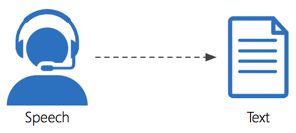

In [1]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00


## Шаг 1 (1 балл)

* Возьмите датасет https://disk.yandex.ru/d/v2Hipv7XG4fEDQ, содержащий русскоязычные аудиозаписи

* Примените модель [whisper-small](https://huggingface.co/openai/whisper-small) из HF для определения сказанного в аудио.

* Выведите результат работы модели для 10 случайных аудио из датасета

Не стесняйтесь пользоваться документацией и источниками знаний из интернета!

In [1]:
import pandas as pd

df = pd.read_csv("urls_normalized.tsv", header=None, sep='\t')
df.columns = ["url"]
df.head()

,url
0,http://storage.mds.yandex.net:80/get-voicetolo...
1,http://storage.mds.yandex.net:80/get-voicetolo...
2,http://storage.mds.yandex.net:80/get-voicetolo...
3,http://storage.mds.yandex.net:80/get-voicetolo...
4,http://storage.mds.yandex.net:80/get-voicetolo...


In [ ]:
!pip uninstall transformers


Found existing installation: transformers 4.57.0
Uninstalling transformers-4.57.0:
  Would remove:
    /usr/local/bin/transformers
    /usr/local/bin/transformers-cli
    /usr/local/lib/python3.12/dist-packages/transformers-4.57.0.dist-info/*
    /usr/local/lib/python3.12/dist-packages/transformers/*
Proceed (Y/n)? y
  Successfully uninstalled transformers-4.57.0


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 47.8 MB/s eta 0:00:00


In [2]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor
import torch
import torchaudio
import random
import requests
import io

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")
model.to(device).eval()

transcriptions = []

for url in df["url"]:
  response = requests.get(url, timeout=15)
  response.raise_for_status()
  audio_bytes = io.BytesIO(response.content)
  wav, sr = torchaudio.load(audio_bytes)
  if wav.shape[0] > 1:
    wav = wav.mean(dim=0, keepdim=True)
  if sr != 16000:
    wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=16000)
    sr = 16000
  sampled_list = wav.squeeze().numpy()

  input_features = processor(sampled_list, sampling_rate=16000, return_tensors="pt", padding=True).input_features.to(device)
  with torch.no_grad():
    predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids, max_length=400)
  transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
  transcriptions.append(transcription)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcod

In [3]:
# Вывод транскрипции для 10 случайных аудио
random_10_urls = random.sample(range(len(transcriptions)), 10)
print("транскрипции для 10 случайных аудио:")
text = []
for i, idx in enumerate(random_10_urls, 1):
  print(f"{i}. {transcriptions[idx]}")
  text.append(transcriptions[idx])

транскрипции для 10 случайных аудио:
1.  Ганди.
2.  Новый кинотеатр пародизо
3.  Таксист.
4.  Помни!
5.  Рене-декарт.
6.  Бред пит
7.  3 идиота
8.  Космическая Одессия 2001 года
9.  Коу-портер
10.  Бабель Исаак, Эммануи Лавич.


## Шаг 2 (1 балл)

Текст распознается с ошибками.
Попробуйте исправить ошибки с помощью готовой (предобученной) модели spell correction.

Выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели https://huggingface.co/UrukHan/t5-russian-spell.

In [4]:
from transformers import AutoModelForSeq2SeqLM, T5TokenizerFast

tokenizer_spell = T5TokenizerFast.from_pretrained('UrukHan/t5-russian-spell')
model_spell = AutoModelForSeq2SeqLM.from_pretrained('UrukHan/t5-russian-spell').to(device).eval()

task_prefix = "Spell correct: "
if type(text) != list:
  text = [text]
encoded = tokenizer_spell(
  [task_prefix + sequence for sequence in text],
  padding="longest",
  max_length=256,
  truncation=True,
  return_tensors="pt",
).to(device)
with torch.no_grad():
  predicts = model_spell.generate(**encoded)
corrected_text = tokenizer_spell.batch_decode(predicts, skip_special_tokens=True)

In [5]:
texts_df = pd.DataFrame({
    'original_text': text,
    'corrected_text': corrected_text
})
texts_df

,original_text,corrected_text
0,Ганди.,Ганди.
1,Новый кинотеатр пародизо,Новый кинотеатр пародии
2,Таксист.,Таксист. .
3,Помни!,Помни!
4,Рене-декарт.,Рене-Декарт.
5,Бред пит,Бред Питт
6,3 идиота,3 идиота.
7,Космическая Одессия 2001 года,"Космическая Одесса, 2001 года"
8,Коу-портер,Коу-портер
9,"Бабель Исаак, Эммануи Лавич.","Бабель Исаак, Эммануэль Лавич."


## Шаг 3 (2 балла)

Соберите данные для дообучения модели выше. Для дообучения мы предлагаем вам использовать бесплатный api Groq: https://console.groq.com/docs/quickstart

Разберитесь с тем как пользоваться api (мы немного поможем вам с этим кодом ниже) и с его помощью соберите датасет (можно в несколько запросов).

- **0.5 балла** ставится за сбор датасета размером >1000 строк и сохранение в локальный файл/файлы

- **еще 0.5 балла** ставится за [создание huggingface dataset](https://huggingface.co/docs/datasets/create_dataset) (через использование библиотек datasets и huggingface) и [сохранение собранного датасета напрямую в HuggingFace](https://huggingface.co/docs/datasets/upload_dataset)

- **еще 1 балл** ставится за сбор датасета размером >1000 строк, на котором путем дообучения получится увеличить качество исправления опечаток в поставленной задаче (см. шаг 6) по сравнению с качеством прогноза той же, но предобученной модели

P.S. Если у Вас нет VPN, то можете воспользоваться другой LLM на Ваш выбор (можно, например, этим https://ollama.com/).

In [ ]:
# зайдите на страницу и создайте API KEY: https://console.groq.com/keys - возможно, понадобится включить VPN

import os

os.environ["GROQ_API_KEY"] = ''

In [8]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.7 MB/s eta 0:00:00


In [7]:
# Генерация хороших предложений на русском языке
import json
import os
from groq import Groq
import time

# client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# all_texts = []

# batch_size = 20
# num_batches = 80

# models = [
#     "llama-3.3-70b-versatile",
#     "llama-3.1-8b-instant",
#     "openai/gpt-oss-120b",
#     "groq/compound"
# ]

# for i in range(num_batches):
#     prompt_good = f"""
#     Сгенерируй {batch_size} коротких предложений на русском языке на темы кино, компьютерные игры, писатели, спорт, музыканты, университеты, машины.
#     Верни результат в виде JSON массива строк строго в формате: ["предложение1", "предложение2", ...]
#     Никакого текста до или после массива не добавляй.
#     """

#     success = False
#     for model_name in models:
#         try:
#             response = client.chat.completions.create(
#                 messages=[{"role": "user", "content": prompt_good}],
#                 model=model_name,
#                 max_tokens=3000,
#                 temperature=0.7,
#                 timeout=60
#             )

#             content = response.choices[0].message.content.strip()

#             json_start = content.find('[')
#             json_end = content.rfind(']')
#             if json_start == -1 or json_end == -1:
#                 raise ValueError("Ответ не содержит JSON массива")

#             json_text = content[json_start:json_end+1]

#             try:
#                 batch_texts = json.loads(json_text)

#             except json.JSONDecodeError as je:
#                 raise ValueError(f"Ошибка JSON парсинга: {je}\nОтвет: {content[:300]}")

#             all_texts.extend(batch_texts)
#             print(f"Батч {i+1} добавлен {model_name}. Всего предложений: {len(all_texts)}")

#             with open("better_texts_partial.json", "w", encoding="utf-8") as f:
#                 json.dump(all_texts, f, ensure_ascii=False, indent=2)

#             success = True
#             time.sleep(3)
#             break

#         except Exception as e:
#             print(f"Ошибка на батче {i+1} с моделью {model_name}: {e}")
#             time.sleep(2)

#     if not success:
#         print(f"Батч {i+1} не удалось сгенерировать ни одной моделью.")
#         time.sleep(5)


In [ ]:
# client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

# with open("better_texts_partial.json", "r", encoding="utf-8") as f:
#     good_texts = json.load(f)

# bad_pairs = []

# models = [
#     "llama-3.3-70b-versatile",
#     "llama-3.1-8b-instant",
#     "openai/gpt-oss-120b",
#     "groq/compound"
# ]


# for idx, text in enumerate(good_texts):
#     prompt = f"""
#     Возьми это предложение:
#     "{text}"
#     Сделай 2 версии этого предложения, добавляя одну или несколько опечаток (ошибки в буквах, пропуски, перестановки и т.п.).
#     Каждый вариант должен содержать 1-2 разные опечатки.
#     Сохрани общий смысл предложения.
#     Используя разные типы ошибок в разных вариантах.
#     Верни строго JSON массив строк: ["версия1", "версия2"]
#     """

#     success = False

#     for model_name in models:
#         try:
#             response = client.chat.completions.create(
#                 messages=[{"role": "user", "content": prompt}],
#                 model=model_name,
#                 max_tokens=3000,
#                 temperature=0.9,
#                 timeout=60
#             )

#             content = response.choices[0].message.content.strip()
#             json_start = content.find('[')
#             json_end = content.rfind(']')
#             if json_start == -1 or json_end == -1:
#                 raise ValueError("Ответ не содержит JSON массива")

#             json_text = content[json_start:json_end + 1]
#             noisy_variants = json.loads(json_text)

#             for bad in noisy_variants:
#                 bad_pairs.append({"original": text, "noisy": bad})

#             print(f"{idx+1}: {model_name} сгенерировала варианты ({len(bad_pairs)} всего)")
#             success = True
#             break

#         except Exception as e:
#             print(f"Ошибка на предложении {idx+1} с моделью {model_name}: {e}")
#             time.sleep(3)

#     if not success:
#         print(f"Не удалось добавить опечатки в {idx+1}, оставляем оригинал.")
#         bad_pairs.append({"original": text, "noisy": text})
#     time.sleep(2)

#   with open("noisy_texts.json", "w", encoding="utf-8") as f:
#       json.dump(bad_pairs, f, ensure_ascii=False, indent=2)


1: llama-3.3-70b-versatile сгенерировала варианты (2 всего)
Ошибка на предложении 2 с моделью llama-3.3-70b-versatile: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01k7c23j5eeh182k0p15nn22bt` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100067, Requested 177. Please try again in 3m31.319999999s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
2: llama-3.1-8b-instant сгенерировала варианты (4 всего)
Ошибка на предложении 3 с моделью llama-3.3-70b-versatile: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01k7c23j5eeh182k0p15nn22bt` service tier `on_demand` on tokens per day (TPD): Limit 100000, Used 100061, Requested 182. Please try again in 3m30.16s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/bi

KeyboardInterrupt: 

Остановил генерацию, так как она заняла более 2 с половиной часов, а сгенерирровал более 1к предложений как и в самом задании


In [ ]:
# Сохраните собранный датасет в файл и прикрепите сюда ссылку на него
with open("noisy_texts.json", "w", encoding="utf-8") as f:
  json.dump(bad_pairs, f, ensure_ascii=False, indent=2)

## Шаг 4 (2 балла)

Дообучите модель выше или любую другую модель, которая вам нравится, на собранных данных и протестируйте ее на нескольких ошибочно распознанных whisper-small моделью аудио. Дообучение мы разбирали на семинаре - можете посмотреть, как мы это делали там.

Для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

- Вы можете воспользовать структурой, предложенной в ячейке ниже, а можете написать код по-своему.

In [10]:
!pip install --upgrade transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.3/506.3 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.


In [8]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments
)
import json

# Загружаем данные
with open("noisy_texts.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Очистка: оставляем только валидные пары (оба поля — непустые строки)
cleaned = []
for i, item in enumerate(data):
    try:
        noisy = item.get("noisy")
        original = item.get("original")

        # Если значение — список, берём первый элемент
        if isinstance(noisy, list):
            noisy = noisy[0] if noisy else ""
        if isinstance(original, list):
            original = original[0] if original else ""

        # Приводим к строке и убираем пробелы
        noisy = str(noisy).strip()
        original = str(original).strip()

        # Пропускаем пустые
        if noisy and original:
            cleaned.append({"noisy": noisy, "original": original})
    except Exception as e:
        print(f"Пропущена запись {i}: {e}")

print(f"Очищено {len(cleaned)} записей из {len(data)}")

# Создаём Dataset из списка словарей — НО только с чистыми строками
# Чтобы избежать ArrowTypeError, используем from_dict через zip
noisy_col = [item["noisy"] for item in cleaned]
original_col = [item["original"] for item in cleaned]

dataset = Dataset.from_dict({
    "noisy": noisy_col,
    "original": original_col
})

# Модель и токенизатор
model_name = "UrukHan/t5-russian-spell"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

#Токенизация
def preprocess_function(examples):
    inputs = ["Spell correct: " + x for x in examples["noisy"]]
    targets = examples["original"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length").input_ids
    model_inputs["labels"] = labels
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)

# Data collator
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

# Аргументы обучения
training_args = Seq2SeqTrainingArguments(
    output_dir="./t5-russian-spell-finetuned",
    eval_strategy="no",
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_steps=100,
    predict_with_generate=True,
    fp16=torch.cuda.is_available(),
    push_to_hub=False,
    report_to="none",
)

#Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Дообучение
print("Начинаем дообучение")
trainer.train()

#Сохранение модели
trainer.save_model("./t5-russian-spell-finetuned")
tokenizer.save_pretrained("./t5-russian-spell-finetuned")

print("Модель успешно дообучена и сохранена!")

Очищено 2061 записей из 2061


Map:   0%|          | 0/2061 [00:00<?, ? examples/s]

/tmp/ipython-input-2859322943.py:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Начинаем дообучение


Step,Training Loss
100,0.859300
200,0.057500
300,0.055500
400,0.050400
500,0.044800
600,0.035800
700,0.033000
800,0.033400
900,0.035700
1000,0.034100


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3922: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 256}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Модель успешно дообучена и сохранена!


Примените дообученную модель. Как раз здесь для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

# Путь к дообученной модели
model_path = "./t5-russian-spell-finetuned"

# Загружаем модель и токенизатор
print("Загружаем дообученную модель")
tokenizer_finetuned = AutoTokenizer.from_pretrained(model_path)
model_finetuned = AutoModelForSeq2SeqLM.from_pretrained(model_path)
model_finetuned.to(device).eval()

# Убедимся, что `text` существует и содержит 10 строк
assert 'text' in globals(), "Переменная `text` (10 транскрипций от Whisper) не определена!"
assert len(text) == 10, f"Ожидалось 10 текстов, но их {len(text)}"

# Подготавливаем входы
task_prefix = "Spell correct: "
inputs = [task_prefix + t for t in text]

# Токенизация
encoded = tokenizer_finetuned(
    inputs,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
).to(device)

# Генерация исправлений
print("Генерируем исправления")
with torch.no_grad():
    generated_ids = model_finetuned.generate(
        **encoded,
        max_length=128,
        num_beams=4,
        early_stopping=True
    )

# Декодируем
finetuned_results = tokenizer_finetuned.batch_decode(generated_ids, skip_special_tokens=True)

# Выводим результат
for i, (orig, corrected) in enumerate(zip(text, finetuned_results), 1):
    print(f"{i}. Было:  \"{orig}\"")
    print(f"   Стало: \"{corrected}\"\n")

Загружаем дообученную модель
Генерируем исправления
1. Было:  " Ганди."
   Стало: "Ганди."

2. Было:  " Новый кинотеатр пародизо"
   Стало: "Новый кинотеатр пародии"

3. Было:  " Таксист."
   Стало: "Таксист."

4. Было:  " Помни!"
   Стало: "Помни!"

5. Было:  " Рене-декарт."
   Стало: "Рене-декарт."

6. Было:  " Бред пит"
   Стало: "Бред Питт"

7. Было:  " 3 идиота"
   Стало: "3 идиота"

8. Было:  " Космическая Одессия 2001 года"
   Стало: "Космическая Одесса 2001 года"

9. Было:  " Коу-портер"
   Стало: "Коу-портер"

10. Было:  " Бабель Исаак, Эммануи Лавич."
   Стало: "Бабель Исаак и Эммануэль Лавич."



## Шаг 5 (1 балл)

Время считать метрики и возвращаться к дообучению модели по необходимости. В этом шаге мы оцениваем только выполнение задания, а не значения метрик.

a) [Здесь](https://disk.yandex.ru/d/SPJU3lCt_cMDcw) лежат правильные ответы почти на все аудио - считайте метрики только для аудио, для которых мы дали вам ответы. Посчитайте [WER](https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html) для модели whisper-small.

б) Посчитайте WER для whisper-small + исправление опечаток предобученной моделью (модель выберите самостоятельно!)

в) Посчитайте WER для whisper-small + дообученная Вами модель (данные для дообучения и модель выберите самостоятельно!)

In [10]:
!pip install torcheval -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 9.0 MB/s eta 0:00:00


In [12]:
import json
import pandas as pd
import requests
import io
import torch
import torchaudio
import soundfile as sf
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    WhisperProcessor,
    WhisperForConditionalGeneration
)
import evaluate

# Загрузка
with open('/content/result_array.json', 'r', encoding='utf-8') as f:
    ground_truths = json.load(f)

# Создаём словарь
url_to_truth = {item['url']: item['text'] for item in ground_truths if 'url' in item and 'text' in item}
print(f"Загружено {len(url_to_truth)} пар (URL → текст)")

# === 2. Загрузка URL из датасета ===
ds = pd.read_csv("/content/urls_normalized.tsv", sep='\t', header=None)
urls = ds[0].tolist()
print(f"Всего URL в датасете: {len(urls)}")

# Отбираем только те URL, для которых есть референс
matched_urls = []
matched_truths = []

for url in urls:
    if url in url_to_truth:
        matched_urls.append(url)
        matched_truths.append(url_to_truth[url])

print(f"Найдено совпадений: {len(matched_urls)}")

Загружено 96 пар (URL → текст)
Всего URL в датасете: 100
Найдено совпадений: 96


In [13]:
urls_to_process = matched_urls
truths_to_use = matched_truths

In [14]:
# Загрузка моделей
device = "cuda" if torch.cuda.is_available() else "cpu"

# Whisper
processor = WhisperProcessor.from_pretrained("openai/whisper-small")
model_whisper = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
forced_decoder_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")
model_whisper.to(device).eval()

# Предобученная
pretrained_model_name = "UrukHan/t5-russian-spell"
pretrained_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
pretrained_model = AutoModelForSeq2SeqLM.from_pretrained(pretrained_model_name).to(device).eval()

# Дообученная модель
finetuned_tokenizer = AutoTokenizer.from_pretrained("./t5-russian-spell-finetuned")
finetuned_model = AutoModelForSeq2SeqLM.from_pretrained("./t5-russian-spell-finetuned").to(device).eval()

In [15]:
#Вспомогательная функция для исправления
def correct_text(text, tokenizer, model):
    inputs = tokenizer(
        "Spell correct: " + text,
        return_tensors="pt",
        max_length=128,
        truncation=True,
        padding=True
    ).to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=128)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [16]:
# Обработка аудио
whisper_results = []
pretrained_results = []
finetuned_results = []
valid_truths = []

for i, (url, truth) in enumerate(zip(urls_to_process, truths_to_use)):
    print(f"\nОбработка {i+1}/{len(urls_to_process)}: {url[:50]}...")

    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        audio_data, sr = sf.read(io.BytesIO(response.content))

        if len(audio_data.shape) > 1:
            audio_data = audio_data.mean(axis=1)

        if sr != 16000:
            audio_tensor = torch.tensor(audio_data, dtype=torch.float32)
            audio_resampled = torchaudio.functional.resample(audio_tensor, orig_freq=sr, new_freq=16000)
            audio_data = audio_resampled.numpy()
            sr = 16000

        input_features = processor(audio_data, sampling_rate=sr, return_tensors="pt").input_features.to(device)
        with torch.no_grad():
            predicted_ids = model_whisper.generate(
                input_features,
                forced_decoder_ids=forced_decoder_ids
            )
        whisper_text = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        corrected_pretrained = correct_text(whisper_text, pretrained_tokenizer, pretrained_model)
        corrected_finetuned = correct_text(whisper_text, finetuned_tokenizer, finetuned_model)

        whisper_results.append(whisper_text)
        pretrained_results.append(corrected_pretrained)
        finetuned_results.append(corrected_finetuned)
        valid_truths.append(truth)

        print(f" Whisper:        {whisper_text}")
        print(f" Предобученная:  {corrected_pretrained}")
        print(f" Дообученная:    {corrected_finetuned}")
        print(f" Референс:       {truth}")

    except Exception as e:
        print(f" Ошибка: {e}")
        continue



Обработка 1/96: http://storage.mds.yandex.net:80/get-voicetoloka/1...
 Whisper:         Жизнь других.
 Предобученная:  Жизнь других.
 Дообученная:    Жизнь других.
 Референс:       жизнь других

Обработка 2/96: http://storage.mds.yandex.net:80/get-voicetoloka/1...
 Whisper:         Аутам Джон.
 Предобученная:  Аутам Джон.
 Дообученная:    Аутам Джон.
 Референс:       элтон джон

Обработка 3/96: http://storage.mds.yandex.net:80/get-voicetoloka/1...
 Whisper:         Побег из Шаушенко
 Предобученная:  Побег из Шаушенко
 Дообученная:    Побег из Шаушенко
 Референс:       побег из шоушенка

Обработка 4/96: http://storage.mds.yandex.net:80/get-voicetoloka/2...
 Whisper:         Мохаммед Али
 Предобученная:  Мохаммед Али
 Дообученная:    Мохаммед Али
 Референс:       мухаммед али

Обработка 5/96: http://storage.mds.yandex.net:80/get-voicetoloka/2...
 Whisper:         Дневник памяти.
 Предобученная:  Дневник памяти.
 Дообученная:    Дневник памяти.
 Референс:       дневник памяти

Обработка 

In [17]:
!pip install jiwer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 65.6 MB/s eta 0:00:00


In [18]:
if len(valid_truths) == 0:
    print("\nНет валидных данных для вычисления WER.")
else:
    wer_metric = evaluate.load("wer")

    wer_whisper = wer_metric.compute(predictions=whisper_results, references=valid_truths)
    wer_pretrained = wer_metric.compute(predictions=pretrained_results, references=valid_truths)
    wer_finetuned = wer_metric.compute(predictions=finetuned_results, references=valid_truths)

    print("result WER (Word Error Rate)")
    print(f"a) whisper-small:                      {wer_whisper:.4f}")
    print(f"b) whisper + предобученная модель:     {wer_pretrained:.4f}")
    print(f"c) whisper + дообученная модель:       {wer_finetuned:.4f}")
    print(f"\nОбработано аудио: {len(valid_truths)}")


result WER (Word Error Rate)
a) whisper-small:                      0.8739
b) whisper + предобученная модель:     0.9435
c) whisper + дообученная модель:       0.9043

Обработано аудио: 96


## Шаг 6 (3 балла)

В этом шаге предлагаем вам провести максимум рисерча и экспериментов для наиболее качественного решения задачи (в бесплатном google colab, без привлечения дополнительных мощностей)

* Поищите предобученные модели, применение которых для задачи speech-to-text дает меньше опечаток (меньше WER)

* Протестируйте несколько spell-correction моделей и сделайте выводы какая из них лучше (с точки зрения WER)

* Возьмите лучшую из найденных моделей и попытайтесь улучшить ее через шаг 4, как делали ранее. Попробуйте немного изменить обучение в шаге 4, чтобы добиться еще более хороших результатов (изменить данные/гиперпараметры и т.п.) и проведите соответствующий эксперимент. Объясните почему ваша модификация шага 4 теоретически может улучшить результаты и сделайте выводы о том, получилось ли улучшить качество (если нет, то предположите почему).

In [37]:
import evaluate
import torch
import torchaudio
import requests
import soundfile as sf
import io

from transformers import (
    WhisperProcessor, WhisperForConditionalGeneration,
    Wav2Vec2Processor, Wav2Vec2ForCTC
)

In [44]:
test_urls = [
    "http://storage.mds.yandex.net:80/get-voicetoloka/1872575/197f271b-b23f-4ee0-b240-e956a172d7af",
    "http://storage.mds.yandex.net:80/get-voicetoloka/1879367/3d8c8d43-f7f2-479b-a857-c90faa5e2faf",
    "http://storage.mds.yandex.net:80/get-voicetoloka/1872575/45161c4c-3f2c-4638-940e-a69404074ebb"
]
test_truths = ["жизнь других", "элтон джон", "побег из шоушенка"]

In [45]:
# Модели
stt_models = {
    "whisper-tiny": (
        WhisperProcessor.from_pretrained("openai/whisper-tiny"),
        WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny").to(device),
        "whisper"
    ),
    "whisper-small": (
        WhisperProcessor.from_pretrained("openai/whisper-small"),
        WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device),
        "whisper"
    ),
    "wav2vec2-ru": (
        Wav2Vec2Processor.from_pretrained("bond005/wav2vec2-large-ru-golos"),
        Wav2Vec2ForCTC.from_pretrained("bond005/wav2vec2-large-ru-golos").to(device),
        "wav2vec2"
    )
}

In [48]:
stt_results = {}

for name, (processor, model, model_type) in stt_models.items():
    print(f"\nТестируем {name}")
    predictions = []

    for url, truth in zip(test_urls, test_truths):
        try:
            response = requests.get(url, timeout=30)
            audio_data, sr = sf.read(io.BytesIO(response.content))

            if len(audio_data.shape) > 1:
                audio_data = audio_data.mean(axis=1)

            if sr != 16000:
                audio_tensor = torch.tensor(audio_data, dtype=torch.float32)
                audio_resampled = torchaudio.functional.resample(audio_tensor, orig_freq=sr, new_freq=16000)
                audio_data = audio_resampled.numpy()
                sr = 16000

            if model_type == "whisper":
                inputs = processor(audio_data, sampling_rate=sr, return_tensors="pt").input_features.to(device)
                forced_ids = processor.get_decoder_prompt_ids(language="russian", task="transcribe")
                outputs = model.generate(inputs, forced_decoder_ids=forced_ids)
                text = processor.batch_decode(outputs, skip_special_tokens=True)[0]
            else:
                inputs = processor(audio_data, sampling_rate=sr, return_tensors="pt", padding=True).input_values.to(device)
                with torch.no_grad():
                    logits = model(inputs).logits
                pred_ids = torch.argmax(logits, dim=-1)
                text = processor.batch_decode(pred_ids)[0]

            predictions.append(text)
            print(f"  {truth} {text}")

        except Exception as e:
            print(f"  Ошибка на {url[:50]}: {e}")
            predictions.append("")

    valid_preds = []
    valid_refs = []
    for pred, ref in zip(predictions, test_truths):
        if pred.strip():
            valid_preds.append(pred.strip())
            valid_refs.append(ref)

    if valid_preds:
        wer = evaluate.load("wer").compute(predictions=valid_preds, references=valid_refs)
        stt_results[name] = wer
        print(f"WER: {wer:.3f}")
    else:
        print("Не удалось получить ни одного валидного предсказания")


Тестируем whisper-tiny
  жизнь других  Жизнь других
  элтон джон  Алтарль Джонт
  побег из шоушенка  Побег из шоушенко.
WER: 0.714

Тестируем whisper-small
  жизнь других  Жизнь других.
  элтон джон  Аутам Джон.
  побег из шоушенка  Побег из Шаушенко
WER: 0.857

Тестируем wav2vec2-ru
  жизнь других жизнь других
  элтон джон арлтен джон
  побег из шоушенка побег из шоушенка
WER: 0.143


вцелом протестировали, но результат оставляет желать лучшего. изначальные модельки имеют метрику выше